In [64]:
import math
import numpy as np
from graphviz import Digraph
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [93]:
class Value:
    
    def __init__(self, data, _children = (), _op = '', label = ''):
        self.data = data
        self._backward = lambda:None
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        rep = f'Value({self.data})'
        return rep
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = _backward
        return result

    def __radd__(self, other): # other + self
        return self + other
    
    def __neg__(self):
        return self * (-1)

    def __sub__(self, other):
        return self + (-other)
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = Value(self.data * other.data, (self, other), '*')
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = _backward
        return result

    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Expected int or float argument"
        result = Value(self.data**other, (self, ), '*')
        def _backward():
            self.grad += (other * self.data**(other - 1)) * result.grad
        result._backward = _backward
        return result
    
    def exp(self):
        x = self.data
        result = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += result.data * result.grad
        result._backward = _backward
        return result
    
    def tanh(self):
        x = self.data
        t = (math.exp(2 * x) - 1) / (math.exp(2 * x) + 1)
        result = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1 - t**2) * result.grad
        result._backward = _backward
        return result
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [66]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    """
    format: png | svg | ...
    
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    
    dot = Digraph(format="svg", graph_attr={'rankdir': "LR"}) #, node_attr={'rankdir': 'TB'})
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name = uid, label = "{ %s |  data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, uid)
    
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [95]:
a = Value(2.0)
b = Value(4.0)
sum([a, b])

Value(6.0)

In [68]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label = "b")

x1w1 = x1 * w1; x1w1.label = "x1 * w1"
x2w2 = x2 * w2; x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"

o = n.tanh(); o.label = "o"

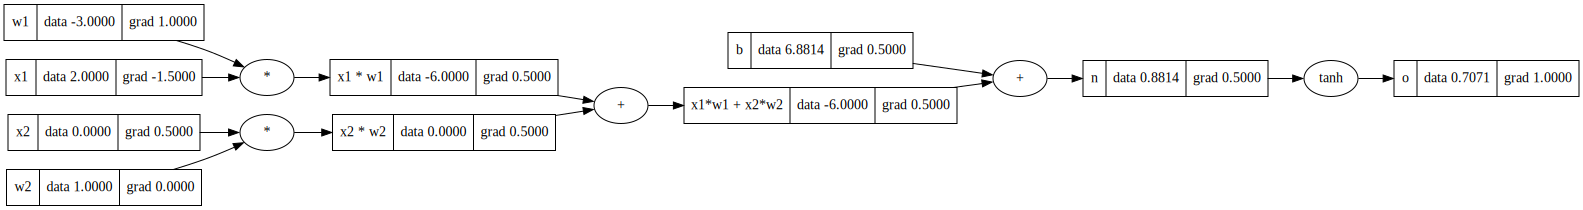

In [69]:
o.backward()
draw_dot(o)

Without tanh

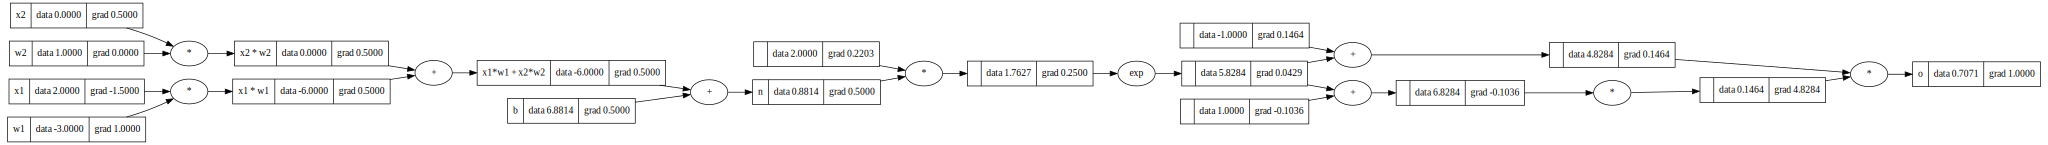

In [70]:
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

b = Value(6.8813735870195432, label = "b")

x1w1 = x1 * w1; x1w1.label = "x1 * w1"
x2w2 = x2 * w2; x2w2.label = "x2 * w2"

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"

n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1)/ (e + 1); o.label = "o"

o.backward()
draw_dot(o)

Building Neural Net Library Multi-Layer Perceptron

In [111]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        #w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        result = act.tanh()
        return result
    
    def parameters(self):
        return self.w + [self.b]
        
class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        out = [n(x) for n in self.neurons]
        return out[0] if len(out) == 1 else out
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        print("nin, nouts ", nin, nouts)
        sz = [nin] + nouts
        print("sz ", sz)
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [112]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

nin, nouts  3 [4, 4, 1]
sz  [3, 4, 4, 1]


Value(0.37464674100441786)

In [113]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [202]:
for k in range(10):
    #forward pass
    ypred = [n(x) for x in xs]
    loss = sum((ytrue - ypred_)**2 for ypred_, ytrue in zip(ys, ypred))

    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()

    #update
    for p in n.parameters():
        p.data += (-0.5) * p.grad

    print(k, loss.data)

0 9.536810575894754e-06
1 9.524848039215735e-06
2 9.512921074497756e-06
3 9.501029518413802e-06
4 9.489173208642274e-06
5 9.477351983866662e-06
6 9.46556568376115e-06
7 9.453814148989876e-06
8 9.442097221192079e-06
9 9.430414742978948e-06


In [204]:
ypred


[Value(0.9988118802772472),
 Value(-0.9999774465981985),
 Value(-0.9989460090317434),
 Value(0.9973718103854011)]

In [119]:
ys

[1.0, -1.0, -1.0, 1.0]